# Demand prediction baseline solution

In [1]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [3]:
test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,348622,2015,3,3,20447918,960.0,820.0,1128.0,1801.0,1045.0,...,1510.0,580.0,969.0,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0
1,348623,2015,3,3,20447902,9086.0,12585.0,11595.0,9685.0,12917.0,...,22055.0,14235.0,21195.0,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0
2,348624,2015,3,3,20447732,115087.0,147287.0,176065.0,143105.0,202069.0,...,302165.0,162232.0,221622.0,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0
3,348625,2015,3,3,20443951,20900.0,24420.0,27068.0,20460.0,25580.0,...,39055.0,14445.0,22450.0,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0
4,348626,2015,3,3,20443944,4430.0,5864.0,3310.0,1853.0,2836.0,...,120.0,130.0,60.0,30.0,50.0,20.0,20.0,30.0,0.0,0.0


In [4]:
def smape(y_pred, y_true):
    assert(len(y_pred) == len(y_true))
    
    numerator = abs(y_pred - y_true)
    denomerator = (abs(y_pred) + abs(y_true)) / 2
    ans = (100.0 / len(y_pred)) * np.sum(numerator / denomerator)
    return ans

In [5]:
frac = 0.4 # fraction of learning examples used for model fitting

# sample the train set if your don't want to deel with all examples
train_sampled = train.sample(frac=frac)

print(len(train_sampled))

28983


In [6]:
only_3_shift = train_sampled[train_sampled['shift'] == 3]
only_not_3_shift = train_sampled[train_sampled['shift'] != 3]
print(len(only_3_shift), len(only_not_3_shift))

9610 19373


In [ ]:
plt.plot([np.sqrt(only_not_3_shift.iloc[ii]['y'])/np.exp(np.mean(only_not_3_shift.iloc[ii][6:])) for ii in range(4000)])

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


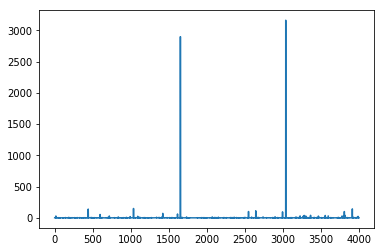

In [144]:
plt.plot([only_not_3_shift.iloc[ii]['y']/np.mean(only_not_3_shift.iloc[ii][6:]) for ii in range(4000)])

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


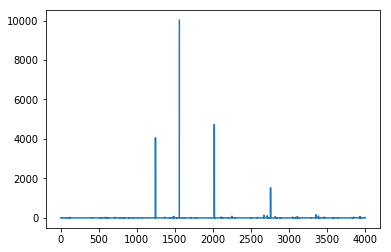

In [143]:
plt.plot([only_3_shift.iloc[ii]['y']/np.mean(only_3_shift.iloc[ii][6:]) for ii in range(4000)])

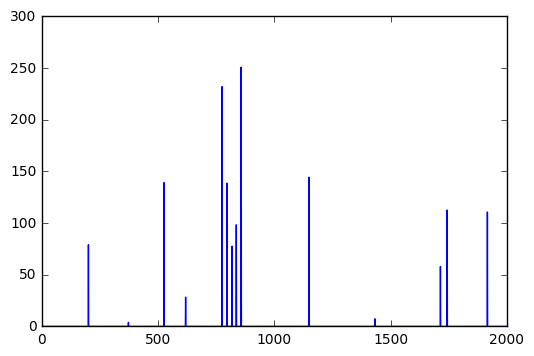

In [146]:
plt.plot([np.sqrt(only_3_shift.iloc[ii]['y'])/np.exp(np.mean(only_3_shift.iloc[ii][6:])) for ii in range(2000)])

In [103]:
only_3_shift_w_mean = only_3_shift.copy()
only_3_shift_w_mean['mean'] = only_3_shift[only_3_shift.columns.values[6:]].mean(axis=1)

In [104]:
only_3_shift_w_mean.head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,mean
13039,62668,329439,2013,20,3,20438609,134778.0,154934.0,183163.0,183232.0,...,259745.0,138289.0,150682.0,153945.0,179322.0,172514.0,159515.0,156672.0,212396.0,179749.466667
59482,294419,370865,2014,37,3,20440556,426616.0,210161.0,337627.0,355510.0,...,577109.0,453775.0,418927.0,408464.0,404300.0,598437.0,272753.0,352972.0,347086.0,399976.000000
1352,4124,17,2013,3,3,20440224,13.0,30.0,45.0,40.0,...,10.0,70.0,40.0,31.0,34.0,100.0,20.0,10.0,170.0,44.000000
6940,31796,474,2013,11,3,20438734,765.0,305.0,417.0,725.0,...,1090.0,380.0,285.0,450.0,450.0,489.0,445.0,480.0,430.0,515.100000
71739,347457,1131,2015,2,3,20440331,1969.0,1230.0,1771.0,2817.0,...,1336.0,903.0,1040.0,1084.0,960.0,784.0,855.0,1179.0,1774.0,1795.533333


# Just to Validate the trained Model

In [167]:
%%time

frac = 0.9
valid = train.sample(frac=frac)

valid_3_shift = valid[valid['shift'] == 3]
valid_others = valid[valid['shift'] != 3]

print(len(valid_3_shift), len(valid_others))

valid_3_shift_w_mean = valid_3_shift.copy()
valid_3_shift_w_mean['mean'] = valid_3_shift[valid_3_shift.columns.values[6:]].mean(axis=1)

valid_others_w_mean = valid_3_shift.copy()
valid_others_w_mean['mean'] = np.exp(valid_others_w_mean[valid_others_w_mean.columns.values[6:]].mean(axis=1))
valid_others_w_mean['y'] = np.sqrt(valid_others_w_mean['y'])

(21443, 43768)
CPU times: user 116 ms, sys: 78 ms, total: 194 ms
Wall time: 197 ms


# XGBoost

In [183]:
%%time

# THIS is the Top model

model_xg = xgboost.XGBRegressor(n_estimators=150, max_depth=20)
model_xg.fit(only_3_shift_w_mean.drop(['Num', 'y'], axis=1), only_3_shift_w_mean['y'])

CPU times: user 10.5 s, sys: 121 ms, total: 10.7 s
Wall time: 11 s


In [184]:
# make predictions for test data
smape(model_xg.predict(valid_3_shift_w_mean.drop(['Num', 'y'], axis=1)), valid_3_shift_w_mean['y'])

25.622998465953064

In [168]:
others = only_not_3_shift.copy()
others['mean'] = np.exp(others[others.columns.values[6:]].mean(axis=1))
others['y'] = np.sqrt(others['y'])

In [169]:
model_xg_other = xgboost.XGBRegressor(n_estimators=150, max_depth=20)
model_xg_other.fit(others.drop(['Num', 'y'], axis=1), others['y'])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [170]:
# make predictions for test data
smape(model_xg_other.predict(valid_others_w_mean.drop(['Num', 'y'], axis=1)), valid_others_w_mean['y'])

14.789272938091155

In [151]:
test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,348622,2015,3,3,20447918,960.0,820.0,1128.0,1801.0,1045.0,...,1510.0,580.0,969.0,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0
1,348623,2015,3,3,20447902,9086.0,12585.0,11595.0,9685.0,12917.0,...,22055.0,14235.0,21195.0,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0
2,348624,2015,3,3,20447732,115087.0,147287.0,176065.0,143105.0,202069.0,...,302165.0,162232.0,221622.0,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0
3,348625,2015,3,3,20443951,20900.0,24420.0,27068.0,20460.0,25580.0,...,39055.0,14445.0,22450.0,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0
4,348626,2015,3,3,20443944,4430.0,5864.0,3310.0,1853.0,2836.0,...,120.0,130.0,60.0,30.0,50.0,20.0,20.0,30.0,0.0,0.0


In [185]:
valid_mean = valid.copy()
valid_mean['mean'] = valid_mean[valid_mean.columns.values[6:]].mean(axis=1)
# valid_mean['y'] = np.sqrt(valid_mean['y'])

In [186]:
smape(model_xg.predict(valid_mean.drop(['Num', 'y'], axis=1)), valid_mean['y'])

29.823236687680541

In [172]:
smape(model_xg_other.predict(valid_mean.drop(['Num', 'y'], axis=1)), valid_mean['y'])

9.6525642692786366

In [187]:
test_mean = test.copy()
test_mean['mean'] = test_mean[test_mean.columns.values[6:]].mean(axis=1)
# test_mean['y'] = np.sqrt(test_mean['y'])

In [191]:
preds = model_xg.predict(test_mean.drop(['Num'], axis=1))


In [192]:
sample_submission['y'] = preds

In [193]:
sample_submission.head(5)

,Num,y
0,348622,2286.835205
1,348623,23867.035156
2,348624,329452.593750
3,348625,37992.535156
4,348626,39.393253


In [180]:
# In GBM you can get some negative predictions:
print sample_submission[sample_submission['y'] < 0]

Empty DataFrame
Columns: [Num, y]
Index: []


In [181]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [182]:
sample_submission.to_csv("baseline_submission.tsv", sep=',', index=False)